# Link Prediction on Cora

In [11]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

dataset = Planetoid("./", name='Cora', transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Processing...
Done!


Epoch: 001, Loss: 0.6930, Val: 0.6833, Test: 0.7031
Epoch: 002, Loss: 0.6833, Val: 0.6812, Test: 0.6972
Epoch: 003, Loss: 0.7039, Val: 0.6885, Test: 0.7066
Epoch: 004, Loss: 0.6784, Val: 0.6980, Test: 0.7239
Epoch: 005, Loss: 0.6852, Val: 0.7068, Test: 0.7394
Epoch: 006, Loss: 0.6878, Val: 0.7131, Test: 0.7451
Epoch: 007, Loss: 0.6883, Val: 0.7073, Test: 0.7348
Epoch: 008, Loss: 0.6870, Val: 0.6965, Test: 0.7197
Epoch: 009, Loss: 0.6830, Val: 0.6891, Test: 0.7076
Epoch: 010, Loss: 0.6761, Val: 0.6857, Test: 0.6987
Epoch: 011, Loss: 0.6698, Val: 0.6835, Test: 0.6920
Epoch: 012, Loss: 0.6734, Val: 0.6832, Test: 0.6921
Epoch: 013, Loss: 0.6685, Val: 0.6930, Test: 0.7060
Epoch: 014, Loss: 0.6586, Val: 0.7174, Test: 0.7335
Epoch: 015, Loss: 0.6553, Val: 0.7420, Test: 0.7504
Epoch: 016, Loss: 0.6487, Val: 0.7464, Test: 0.7467
Epoch: 017, Loss: 0.6378, Val: 0.7380, Test: 0.7356
Epoch: 018, Loss: 0.6248, Val: 0.7408, Test: 0.7335
Epoch: 019, Loss: 0.6165, Val: 0.7703, Test: 0.7496
Epoch: 020, 

# Link Prediction on Senators

In [14]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
# from models.GLASE_unshared_normalized_v2 import gLASE_v2
import matplotlib.pyplot as plt

torch.manual_seed(42)

d = 4
n_P1 = 100
# n_P2 = 100
n_P2 = 50
n_L1 = 100
# n_L2 = 100
n_L2 = 200
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.1
P1_L3 = 0.3  
P2_L1 = 0.1
P2_L2 = 0.9
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 80
n_P2_np = 80
# n_P2_np = 40
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos


## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
list_q.sort(reverse=True)
# q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)


x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


tensor([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(43.7876)


In [15]:
gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 400

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


tensor(97.9246, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(57.4205, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(54.2652, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(53.0740, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


tensor(50.3964, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


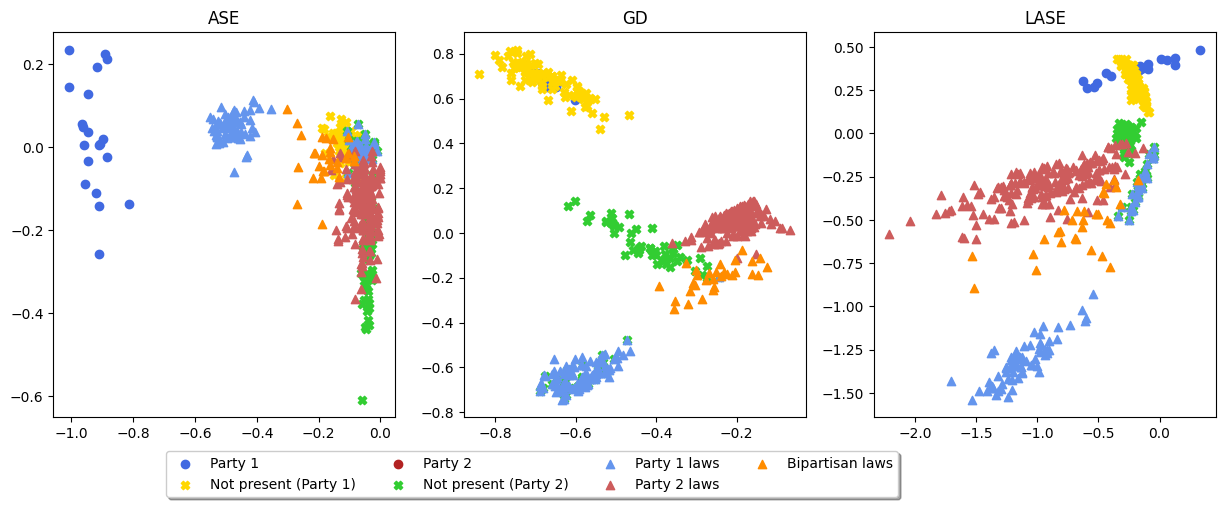

In [16]:
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')


fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

## Label features

In [6]:
## Node features -- One hot encoding of label P1, P2, L1, L2, L3

import torch.nn.functional as F

labels = np.concatenate((np.ones(n_P1)*0,np.ones(n_P2), np.ones(n_L1)*2, np.ones(n_L2)*3, np.ones(n_L3)*4))
labels = labels.tolist()
labels = torch.tensor(labels).long()
labels = F.one_hot(labels)



labels.shape

torch.Size([380, 5])

In [243]:
labels

tensor([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]])

In [8]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=labels.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

### GCN embeddings

In [9]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(5, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6929, Val: 0.9109, Test: 0.8962
Epoch: 002, Loss: 0.6478, Val: 0.9019, Test: 0.8843
Epoch: 003, Loss: 0.6156, Val: 0.8797, Test: 0.8647
Epoch: 004, Loss: 0.5787, Val: 0.8749, Test: 0.8593
Epoch: 005, Loss: 0.5600, Val: 0.8679, Test: 0.8514
Epoch: 006, Loss: 0.5605, Val: 0.8743, Test: 0.8544
Epoch: 007, Loss: 0.5578, Val: 0.8743, Test: 0.8550
Epoch: 008, Loss: 0.5525, Val: 0.8749, Test: 0.8539
Epoch: 009, Loss: 0.5431, Val: 0.8783, Test: 0.8548
Epoch: 010, Loss: 0.5413, Val: 0.8799, Test: 0.8563
Epoch: 011, Loss: 0.5432, Val: 0.8802, Test: 0.8560
Epoch: 012, Loss: 0.5417, Val: 0.8797, Test: 0.8549
Epoch: 013, Loss: 0.5385, Val: 0.8801, Test: 0.8561
Epoch: 014, Loss: 0.5393, Val: 0.8794, Test: 0.8570
Epoch: 015, Loss: 0.5390, Val: 0.8795, Test: 0.8571
Epoch: 016, Loss: 0.5385, Val: 0.8787, Test: 0.8565
Epoch: 017, Loss: 0.5346, Val: 0.8772, Test: 0.8560
Epoch: 018, Loss: 0.5390, Val: 0.8771, Test: 0.8560
Epoch: 019, Loss: 0.5334, Val: 0.8769, Test: 0.8562
Epoch: 020, 

In [10]:
## Predict on entire masked graph

z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')

In [11]:
adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [12]:
adj_matrix[senadores_no_presentes][:,n_P1+n_P2:].shape

torch.Size([48, 230])

In [13]:
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / 48 / 230

tensor(0.8604)

### ASE embeddings

In [14]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6901, Val: 0.8946, Test: 0.8835
Epoch: 002, Loss: 0.6330, Val: 0.8840, Test: 0.8689
Epoch: 003, Loss: 0.5941, Val: 0.8782, Test: 0.8613
Epoch: 004, Loss: 0.5537, Val: 0.8779, Test: 0.8574
Epoch: 005, Loss: 0.5509, Val: 0.8788, Test: 0.8562
Epoch: 006, Loss: 0.5619, Val: 0.8800, Test: 0.8563
Epoch: 007, Loss: 0.5363, Val: 0.8796, Test: 0.8552
Epoch: 008, Loss: 0.5334, Val: 0.8782, Test: 0.8540
Epoch: 009, Loss: 0.5376, Val: 0.8797, Test: 0.8558
Epoch: 010, Loss: 0.5494, Val: 0.8797, Test: 0.8570
Epoch: 011, Loss: 0.5422, Val: 0.8789, Test: 0.8572
Epoch: 012, Loss: 0.5431, Val: 0.8784, Test: 0.8570
Epoch: 013, Loss: 0.5417, Val: 0.8780, Test: 0.8573
Epoch: 014, Loss: 0.5347, Val: 0.8786, Test: 0.8566
Epoch: 015, Loss: 0.5312, Val: 0.8794, Test: 0.8560
Epoch: 016, Loss: 0.5382, Val: 0.8796, Test: 0.8557
Epoch: 017, Loss: 0.5344, Val: 0.8797, Test: 0.8557
Epoch: 018, Loss: 0.5309, Val: 0.8791, Test: 0.8561
Epoch: 019, Loss: 0.5350, Val: 0.8791, Test: 0.8569
Epoch: 020, 

In [15]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / 48 / 230

tensor(0.8276)

### GLASE embeddings

In [16]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.9126, Val: 0.7181, Test: 0.6946
Epoch: 002, Loss: 0.6863, Val: 0.7589, Test: 0.7235
Epoch: 003, Loss: 0.6503, Val: 0.7725, Test: 0.7417
Epoch: 004, Loss: 0.6319, Val: 0.8122, Test: 0.7988
Epoch: 005, Loss: 0.6119, Val: 0.8434, Test: 0.8359
Epoch: 006, Loss: 0.5813, Val: 0.8629, Test: 0.8494
Epoch: 007, Loss: 0.5719, Val: 0.8715, Test: 0.8499
Epoch: 008, Loss: 0.5638, Val: 0.8738, Test: 0.8505
Epoch: 009, Loss: 0.5510, Val: 0.8760, Test: 0.8530
Epoch: 010, Loss: 0.5423, Val: 0.8796, Test: 0.8566
Epoch: 011, Loss: 0.5639, Val: 0.8812, Test: 0.8583
Epoch: 012, Loss: 0.5478, Val: 0.8813, Test: 0.8579
Epoch: 013, Loss: 0.5420, Val: 0.8809, Test: 0.8573
Epoch: 014, Loss: 0.5383, Val: 0.8801, Test: 0.8570
Epoch: 015, Loss: 0.5342, Val: 0.8792, Test: 0.8572
Epoch: 016, Loss: 0.5366, Val: 0.8786, Test: 0.8566
Epoch: 017, Loss: 0.5367, Val: 0.8778, Test: 0.8558
Epoch: 018, Loss: 0.5422, Val: 0.8770, Test: 0.8547
Epoch: 019, Loss: 0.5379, Val: 0.8755, Test: 0.8547
Epoch: 020, 

In [17]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / 48 / 230

tensor(0.8653)

## Random features

In [17]:
torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
random_features

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        ...,
        [0.8276, 0.9544, 0.1218, 0.7100, 0.2182],
        [0.1134, 0.4780, 0.2132, 0.0694, 0.0327],
        [0.1653, 0.9109, 0.7789, 0.3021, 0.1653]])

In [18]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

### GCN Embeddings

In [19]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(5, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6697, Val: 0.7305, Test: 0.7177
Epoch: 002, Loss: 0.6806, Val: 0.7419, Test: 0.7341
Epoch: 003, Loss: 0.6870, Val: 0.7420, Test: 0.7331
Epoch: 004, Loss: 0.6722, Val: 0.7459, Test: 0.7361
Epoch: 005, Loss: 0.6757, Val: 0.7499, Test: 0.7404
Epoch: 006, Loss: 0.6736, Val: 0.7525, Test: 0.7437
Epoch: 007, Loss: 0.6671, Val: 0.7524, Test: 0.7446
Epoch: 008, Loss: 0.6627, Val: 0.7539, Test: 0.7466
Epoch: 009, Loss: 0.6690, Val: 0.7552, Test: 0.7481
Epoch: 010, Loss: 0.6581, Val: 0.7562, Test: 0.7498
Epoch: 011, Loss: 0.6577, Val: 0.7573, Test: 0.7521
Epoch: 012, Loss: 0.6572, Val: 0.7582, Test: 0.7537
Epoch: 013, Loss: 0.6518, Val: 0.7592, Test: 0.7555
Epoch: 014, Loss: 0.6484, Val: 0.7604, Test: 0.7568
Epoch: 015, Loss: 0.6493, Val: 0.7612, Test: 0.7579
Epoch: 016, Loss: 0.6469, Val: 0.7613, Test: 0.7585
Epoch: 017, Loss: 0.6418, Val: 0.7603, Test: 0.7591
Epoch: 018, Loss: 0.6443, Val: 0.7612, Test: 0.7603
Epoch: 019, Loss: 0.6411, Val: 0.7623, Test: 0.7611
Epoch: 020, 

In [20]:
## Predict on entire masked graph

z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / (n_L1 + n_L2 + n_L3)


tensor(0.4646)

### ASE Embeddings

In [21]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.7050, Val: 0.7268, Test: 0.7066
Epoch: 002, Loss: 0.6750, Val: 0.7590, Test: 0.7476
Epoch: 003, Loss: 0.6933, Val: 0.7673, Test: 0.7528
Epoch: 004, Loss: 0.6656, Val: 0.7738, Test: 0.7565
Epoch: 005, Loss: 0.6650, Val: 0.7772, Test: 0.7549
Epoch: 006, Loss: 0.6654, Val: 0.7773, Test: 0.7525
Epoch: 007, Loss: 0.6607, Val: 0.7775, Test: 0.7529
Epoch: 008, Loss: 0.6514, Val: 0.7783, Test: 0.7542
Epoch: 009, Loss: 0.6463, Val: 0.7803, Test: 0.7555
Epoch: 010, Loss: 0.6490, Val: 0.7823, Test: 0.7552
Epoch: 011, Loss: 0.6403, Val: 0.7834, Test: 0.7535
Epoch: 012, Loss: 0.6356, Val: 0.7810, Test: 0.7499
Epoch: 013, Loss: 0.6315, Val: 0.7774, Test: 0.7455
Epoch: 014, Loss: 0.6279, Val: 0.7762, Test: 0.7431
Epoch: 015, Loss: 0.6222, Val: 0.7754, Test: 0.7423
Epoch: 016, Loss: 0.6183, Val: 0.7723, Test: 0.7392
Epoch: 017, Loss: 0.6131, Val: 0.7659, Test: 0.7296
Epoch: 018, Loss: 0.6096, Val: 0.7614, Test: 0.7129
Epoch: 019, Loss: 0.6115, Val: 0.7379, Test: 0.7089
Epoch: 020, 

In [22]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / (n_L1 + n_L2 + n_L3)

tensor(0.7337)

### GLASE Embeddings

In [23]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.9386, Val: 0.5728, Test: 0.5463
Epoch: 002, Loss: 0.7005, Val: 0.7178, Test: 0.6992
Epoch: 003, Loss: 0.6910, Val: 0.7487, Test: 0.7327
Epoch: 004, Loss: 0.6908, Val: 0.7542, Test: 0.7363
Epoch: 005, Loss: 0.6768, Val: 0.7554, Test: 0.7316
Epoch: 006, Loss: 0.6690, Val: 0.7578, Test: 0.7271
Epoch: 007, Loss: 0.6661, Val: 0.7622, Test: 0.7238
Epoch: 008, Loss: 0.6600, Val: 0.7696, Test: 0.7268
Epoch: 009, Loss: 0.6540, Val: 0.7741, Test: 0.7313
Epoch: 010, Loss: 0.6486, Val: 0.7745, Test: 0.7323
Epoch: 011, Loss: 0.6400, Val: 0.7693, Test: 0.7279
Epoch: 012, Loss: 0.6376, Val: 0.7581, Test: 0.7196
Epoch: 013, Loss: 0.6292, Val: 0.7486, Test: 0.7113
Epoch: 014, Loss: 0.6280, Val: 0.7436, Test: 0.7054
Epoch: 015, Loss: 0.6225, Val: 0.7435, Test: 0.7034
Epoch: 016, Loss: 0.6167, Val: 0.7432, Test: 0.7029
Epoch: 017, Loss: 0.6087, Val: 0.7443, Test: 0.7037
Epoch: 018, Loss: 0.6037, Val: 0.7566, Test: 0.7147
Epoch: 019, Loss: 0.6038, Val: 0.7606, Test: 0.7383
Epoch: 020, 

In [24]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / (n_L1 + n_L2 + n_L3)

tensor(0.7603)

### GRDPG

In [46]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.7426, Val: 0.6737, Test: 0.6621
Epoch: 002, Loss: 0.6878, Val: 0.8423, Test: 0.8082
Epoch: 003, Loss: 0.6708, Val: 0.8571, Test: 0.8260
Epoch: 004, Loss: 0.6635, Val: 0.8691, Test: 0.8522
Epoch: 005, Loss: 0.6459, Val: 0.8641, Test: 0.8548
Epoch: 006, Loss: 0.6362, Val: 0.8437, Test: 0.8399
Epoch: 007, Loss: 0.6271, Val: 0.8298, Test: 0.8310
Epoch: 008, Loss: 0.6136, Val: 0.8240, Test: 0.8293
Epoch: 009, Loss: 0.6011, Val: 0.8218, Test: 0.8302
Epoch: 010, Loss: 0.5850, Val: 0.8196, Test: 0.8302
Epoch: 011, Loss: 0.5822, Val: 0.8173, Test: 0.8303
Epoch: 012, Loss: 0.5798, Val: 0.8129, Test: 0.8284
Epoch: 013, Loss: 0.5805, Val: 0.8109, Test: 0.8275
Epoch: 014, Loss: 0.5782, Val: 0.8125, Test: 0.8282
Epoch: 015, Loss: 0.5736, Val: 0.8104, Test: 0.8254
Epoch: 016, Loss: 0.5723, Val: 0.8114, Test: 0.8263
Epoch: 017, Loss: 0.5813, Val: 0.8122, Test: 0.8278
Epoch: 018, Loss: 0.5755, Val: 0.8113, Test: 0.8273
Epoch: 019, Loss: 0.5724, Val: 0.8130, Test: 0.8286
Epoch: 020, 

In [47]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / (n_L1 + n_L2 + n_L3)

tensor(0.8257)

## Vector of ones

In [30]:
torch.manual_seed(42)
ones_features=torch.ones([410, 5])
ones_features

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [31]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

### GCN Embeddings

In [32]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(5, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6809, Val: 0.7945, Test: 0.7740
Epoch: 002, Loss: 0.6746, Val: 0.7971, Test: 0.7769
Epoch: 003, Loss: 0.6950, Val: 0.7963, Test: 0.7767
Epoch: 004, Loss: 0.6680, Val: 0.7958, Test: 0.7767
Epoch: 005, Loss: 0.6728, Val: 0.7960, Test: 0.7770
Epoch: 006, Loss: 0.6740, Val: 0.7967, Test: 0.7769
Epoch: 007, Loss: 0.6702, Val: 0.7971, Test: 0.7770
Epoch: 008, Loss: 0.6666, Val: 0.7976, Test: 0.7770
Epoch: 009, Loss: 0.6665, Val: 0.7977, Test: 0.7771
Epoch: 010, Loss: 0.6687, Val: 0.7976, Test: 0.7770
Epoch: 011, Loss: 0.6626, Val: 0.7970, Test: 0.7770
Epoch: 012, Loss: 0.6600, Val: 0.7965, Test: 0.7766
Epoch: 013, Loss: 0.6582, Val: 0.7964, Test: 0.7763
Epoch: 014, Loss: 0.6561, Val: 0.7963, Test: 0.7763
Epoch: 015, Loss: 0.6524, Val: 0.7970, Test: 0.7766
Epoch: 016, Loss: 0.6488, Val: 0.7971, Test: 0.7768
Epoch: 017, Loss: 0.6482, Val: 0.7968, Test: 0.7768
Epoch: 018, Loss: 0.6453, Val: 0.7962, Test: 0.7761
Epoch: 019, Loss: 0.6414, Val: 0.7954, Test: 0.7750
Epoch: 020, 

In [33]:
## Predict on entire masked graph

z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230


tensor(0.5545)

### ASE Embeddings

In [34]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6694, Val: 0.8427, Test: 0.8247
Epoch: 002, Loss: 0.6670, Val: 0.8461, Test: 0.8198
Epoch: 003, Loss: 0.6483, Val: 0.8730, Test: 0.8557
Epoch: 004, Loss: 0.6304, Val: 0.8706, Test: 0.8652
Epoch: 005, Loss: 0.6054, Val: 0.8490, Test: 0.8508
Epoch: 006, Loss: 0.5772, Val: 0.8428, Test: 0.8379
Epoch: 007, Loss: 0.5562, Val: 0.8371, Test: 0.8408
Epoch: 008, Loss: 0.5409, Val: 0.8396, Test: 0.8331
Epoch: 009, Loss: 0.5562, Val: 0.8187, Test: 0.8304
Epoch: 010, Loss: 0.5673, Val: 0.8372, Test: 0.8344
Epoch: 011, Loss: 0.5494, Val: 0.8351, Test: 0.8300
Epoch: 012, Loss: 0.5546, Val: 0.8293, Test: 0.8346
Epoch: 013, Loss: 0.5419, Val: 0.8241, Test: 0.8326
Epoch: 014, Loss: 0.5455, Val: 0.8312, Test: 0.8298
Epoch: 015, Loss: 0.5385, Val: 0.8334, Test: 0.8291
Epoch: 016, Loss: 0.5485, Val: 0.8347, Test: 0.8319
Epoch: 017, Loss: 0.5405, Val: 0.8370, Test: 0.8389
Epoch: 018, Loss: 0.5395, Val: 0.8387, Test: 0.8411
Epoch: 019, Loss: 0.5379, Val: 0.8420, Test: 0.8413
Epoch: 020, 

In [35]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230

tensor(0.8357)

### GLASE Embeddings

In [36]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.8382, Val: 0.6897, Test: 0.7031
Epoch: 002, Loss: 0.6994, Val: 0.7442, Test: 0.7525
Epoch: 003, Loss: 0.6994, Val: 0.7943, Test: 0.7836
Epoch: 004, Loss: 0.6782, Val: 0.8038, Test: 0.7913
Epoch: 005, Loss: 0.6596, Val: 0.8057, Test: 0.7909
Epoch: 006, Loss: 0.6519, Val: 0.7889, Test: 0.7664
Epoch: 007, Loss: 0.6490, Val: 0.7955, Test: 0.7749
Epoch: 008, Loss: 0.6417, Val: 0.8108, Test: 0.7998
Epoch: 009, Loss: 0.6352, Val: 0.8050, Test: 0.7956
Epoch: 010, Loss: 0.6222, Val: 0.7920, Test: 0.7842
Epoch: 011, Loss: 0.6096, Val: 0.7921, Test: 0.7866
Epoch: 012, Loss: 0.6048, Val: 0.8015, Test: 0.7905
Epoch: 013, Loss: 0.5982, Val: 0.8124, Test: 0.8027
Epoch: 014, Loss: 0.5842, Val: 0.8129, Test: 0.8052
Epoch: 015, Loss: 0.5827, Val: 0.8105, Test: 0.8022
Epoch: 016, Loss: 0.5685, Val: 0.8095, Test: 0.8089
Epoch: 017, Loss: 0.5680, Val: 0.8197, Test: 0.8168
Epoch: 018, Loss: 0.5601, Val: 0.8284, Test: 0.8236
Epoch: 019, Loss: 0.5519, Val: 0.8314, Test: 0.8238
Epoch: 020, 

In [37]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230

tensor(0.8571)

# UN Dataset

In [4]:
import os
import requests
from tqdm import tqdm
import pandas as pd
import pycountry_convert as pc
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler

resolutions_issues = {'me': 'Palestinian conflict', 
                      'nu': 'Nuclear weapons and nuclear material', 
                      'di': 'Arms control and disarmament',
                      'co': 'Colonialism',
                      'hr': 'Human rights',
                      'ec': 'Economic Development',
                      'N/A': 'Not specified'}

resolutions_issues_color = {'me': 'salmon', 
                            'nu': 'yellow', 
                            'di': 'teal',
                            'co': 'orchid',
                            'hr': 'navy',
                            'ec': 'orange',
                            'N/A': 'black'}

continents_colors = {'North America': 'yellow',
                     'South America': 'forestgreen',
                     'Europe': 'royalblue',
                     'Africa': 'plum',
                     'Asia': 'darkorange',
                     'Oceania': 'firebrick'}

cycler_colors = ['royalblue','firebrick','forestgreen','olive']


def load_un_dataset(un_data_path, initial_year=1946, final_year=2018, remove_nonmembers=True, remove_nonpresent=False, unknown_votes=False):
    
    if os.path.isdir(os.path.dirname(un_data_path)):
        if not os.path.exists(un_data_path):
            download_un_dataset(un_data_path)
    else:
        raise Exception("Provided path for UN dataset is not reachable")
    
    # Load data    
    votes_df = pd.read_csv(un_data_path, low_memory=False, encoding='latin-1', index_col=0)
    # Keep only desired years
    votes_df = votes_df[votes_df.year>=initial_year]
    votes_df = votes_df[votes_df.year<=final_year]
    
    if remove_nonmembers:
        # Remove votes by nonmembers
        votes_df = votes_df[votes_df.vote!=9]
    
    if remove_nonpresent:
        # Remove votes by nonmembers
        votes_df = votes_df[votes_df.vote!=8]
        
    # Edges in graph represent an affirmative vote
    votes_df['weight'] = (votes_df.vote==1)
    
    if unknown_votes:
        # Voters preference is assumed unknown if it is an abstention or voter is not present
        votes_df['unknown'] =  (votes_df.vote==2) | (votes_df.vote==8)
    
    votes_df['res_features'] = votes_df[['me','nu','di','co','hr','ec']].apply(lambda row: np.array(row), axis=1)

    return votes_df

        
def download_un_dataset(filename='UNVotes-1.csv', data_url='https://dataverse.harvard.edu/api/access/datafile/6358426'):
    # Code from https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51
    response = requests.get(data_url, stream=True)
    total_size = int(response.headers.get('content-length',0))
    with open(filename, "wb") as f, tqdm(desc='Downloading UN dataset', total=total_size, unit='B', unit_divisor=1024, unit_scale=True) as pbar:
        for un_data in response.iter_content(chunk_size=1024):
            size = f.write(un_data)
            pbar.update(size)
            
def get_continents_dict(votes_df):
    continents_dict = {}
    countries = votes_df.Country.unique()
    for country in countries: 
        try:
            continent_code = pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(country))
            continents_dict[country] = pc.convert_continent_code_to_continent_name(continent_code)
        except:
            continue
            # print(pais)
            
    continents_dict['DDR'] = 'Europe'
    continents_dict['CSK'] = 'Europe'
    continents_dict['YUG'] = 'Europe'
    continents_dict['EAZ'] = 'Africa'
    continents_dict['YAR'] = 'Asia'
    continents_dict['TLS'] = 'Asia'
    
    return continents_dict

def get_countries_name_conversion_dict(votes_df):
    countries = votes_df.Countryname.unique()
    conversion_dict = {}
    for country in countries: 
        conversion_dict[country] = votes_df[votes_df.Countryname==country].Country.unique()[0]
        
    return conversion_dict

def create_un_graphs(votes_df):
    
    continents_dict = get_continents_dict(votes_df)
    conversion_dict = get_countries_name_conversion_dict(votes_df)
    
    all_graphs = {}
    
    initial_year = votes_df.year.min()
    final_year = votes_df.year.max()
    
    edge_attr = ['weight', 'unknown'] if 'unknown' in votes_df.columns else 'weight'    
    
    for year in range(initial_year,final_year+1):
        
        votes_df_year= votes_df[votes_df.year==year]
        
        g = nx.from_pandas_edgelist(votes_df_year,source='Countryname',target='resid',edge_attr=edge_attr,create_using=nx.DiGraph())
        if g.number_of_edges()>0:
            
            countries_list = votes_df_year.Countryname.unique()
            
            # Add country's code and continent as graph attributes
            countries_codes = {}
            countries_continents = {}
            nodes_colors = {}
            node_types = {}
            for country in countries_list:
                countries_codes[country] = conversion_dict[country]
                countries_continents[country] = continents_dict[conversion_dict[country]]
                nodes_colors[country] = continents_colors[countries_continents[country]]
                node_types[country] = "country"
                
            nx.set_node_attributes(g, countries_codes, name='country code')
            nx.set_node_attributes(g, countries_continents, name='continent')
            
            
            
            # Add resolution's issue as graph attribute
            resolutions_list = votes_df_year.resid.unique()
            resolutions_issues_dict = {}
            important_resolutions_dict = {}
            resolutions_features = {}

            
            for resolution_id in resolutions_list:
                df_votes_sum = votes_df_year[votes_df_year.resid==resolution_id][['me','nu','di','co','hr','ec']].sum()
                if df_votes_sum.max()>0:
                    resolutions_issues_dict[resolution_id] = df_votes_sum.idxmax()
                else:
                    resolutions_issues_dict[resolution_id] = 'N/A'
                    
                nodes_colors[resolution_id] = resolutions_issues_color[resolutions_issues_dict[resolution_id]]
                resolutions_features[resolution_id] = votes_df_year[votes_df_year.resid==resolution_id]['res_features'].mean()
                node_types[resolution_id] = "resolution"
                
                important_vote = votes_df_year[votes_df_year.resid==resolution_id]['importantvote'].max()
                if important_vote > 0:
                    important_resolutions_dict[resolution_id] = True
                else:
                    important_resolutions_dict[resolution_id] = False
            
            nx.set_node_attributes(g, resolutions_issues_dict,name='issue code')
            nx.set_node_attributes(g, nodes_colors, name='color')
            nx.set_node_attributes(g, important_resolutions_dict, name='important vote')
            nx.set_node_attributes(g, node_types, name='type') 
            nx.set_node_attributes(g, resolutions_features, name='res_features') 
                
            all_graphs[year] = g
            
    return all_graphs

In [5]:
votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)
votes_df

,rcid,ccode,member,vote,Country,Countryname,year,session,abstain,yes,...,nu,di,hr,co,ec,ident,resid,weight,unknown,res_features
1,3,2,1.0,1,USA,United States of America,1946,1,4.0,29.0,...,0,0,0,0,0,0.0,1001,True,False,"[0, 0, 0, 0, 0, 0]"
2,3,20,1.0,3,CAN,Canada,1946,1,4.0,29.0,...,0,0,0,0,0,0.0,1001,False,False,"[0, 0, 0, 0, 0, 0]"
4,3,40,1.0,1,CUB,Cuba,1946,1,4.0,29.0,...,0,0,0,0,0,0.0,1001,True,False,"[0, 0, 0, 0, 0, 0]"
5,3,41,1.0,1,HTI,Haiti,1946,1,4.0,29.0,...,0,0,0,0,0,0.0,1001,True,False,"[0, 0, 0, 0, 0, 0]"
6,3,42,1.0,1,DOM,Dominican Republic,1946,1,4.0,29.0,...,0,0,0,0,0,0.0,1001,True,False,"[0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199018,6102,552,1.0,1,ZWE,Zimbabwe,2018,73,12.0,156.0,...,0,0,0,0,0,0.0,73090,True,False,"[0, 0, 0, 0, 0, 0]"
1199019,6138,552,1.0,1,ZWE,Zimbabwe,2018,73,33.0,94.0,...,0,0,0,0,0,0.0,73091,True,False,"[0, 0, 0, 0, 0, 0]"
1199020,6139,552,1.0,1,ZWE,Zimbabwe,2018,73,0.0,188.0,...,0,0,0,0,1,0.0,73092,True,False,"[0, 0, 0, 0, 0, 1]"
1199021,6097,552,1.0,1,ZWE,Zimbabwe,2018,73,1.0,180.0,...,0,0,0,0,0,0.0,73093,True,False,"[0, 0, 0, 0, 0, 0]"


In [6]:
votes_df.columns

Index(['rcid', 'ccode', 'member', 'vote', 'Country', 'Countryname', 'year',
       'session', 'abstain', 'yes', 'no', 'importantvote', 'date', 'unres',
       'amend', 'para', 'short', 'descr', 'me', 'nu', 'di', 'hr', 'co', 'ec',
       'ident', 'resid', 'weight', 'unknown', 'res_features'],
      dtype='object')

In [7]:
all_graphs = create_un_graphs(votes_df)

In [68]:
G = all_graphs[2018].to_undirected()
# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        features.append(np.ones(6))
    else:
        res_indexes.append(node)
        features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    


adj_matrix = nx.adjacency_matrix(G).todense().astype(int)


In [69]:
import torch
import random


num_nodes = adj_matrix.shape[0]

edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)

random.seed(42)
# not_present_countries = random.sample(country_indexes, 10)

for i in country_indexes:
    votos = (torch.rand(1, num_nodes) < 0.3).int()
    mask[i,:] = votos
    mask[:,i] = votos



In [37]:
features = torch.tensor(features)
features

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]], dtype=torch.float64)

In [56]:
## ASE 

d = 6
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)


x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))

tensor([[-1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]])
Iteraciones:  100
Loss:  tensor(16.3506)


In [58]:
gd_steps = 10
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


x_glase = out.detach().to('cpu')

tensor(56.0560, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(23.0081, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(21.7985, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(26.5601, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(21.6407, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(21.0882, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(20.8992, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(20.5893, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(20.2220, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(20.0568, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [61]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)
# torch.manual_seed(42)
# random_features=torch.rand([288, 6])
# random_features

data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)


transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

### GCN Embeddings

In [62]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(6, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 1.1535, Val: 0.3751, Test: 0.3485
Epoch: 002, Loss: 0.7430, Val: 0.3933, Test: 0.3717
Epoch: 003, Loss: 0.7176, Val: 0.4130, Test: 0.3915
Epoch: 004, Loss: 0.7347, Val: 0.4162, Test: 0.3878
Epoch: 005, Loss: 0.7339, Val: 0.4079, Test: 0.3785
Epoch: 006, Loss: 0.7240, Val: 0.4022, Test: 0.3710
Epoch: 007, Loss: 0.7141, Val: 0.4022, Test: 0.3639
Epoch: 008, Loss: 0.7069, Val: 0.4091, Test: 0.3573
Epoch: 009, Loss: 0.7030, Val: 0.4162, Test: 0.3424
Epoch: 010, Loss: 0.7000, Val: 0.4208, Test: 0.3247
Epoch: 011, Loss: 0.6993, Val: 0.4334, Test: 0.3181
Epoch: 012, Loss: 0.6969, Val: 0.4635, Test: 0.3412
Epoch: 013, Loss: 0.6963, Val: 0.5278, Test: 0.3952
Epoch: 014, Loss: 0.6954, Val: 0.6175, Test: 0.4778
Epoch: 015, Loss: 0.6946, Val: 0.6795, Test: 0.5387
Epoch: 016, Loss: 0.6940, Val: 0.7073, Test: 0.5778
Epoch: 017, Loss: 0.6932, Val: 0.7202, Test: 0.6027
Epoch: 018, Loss: 0.6920, Val: 0.7227, Test: 0.6140
Epoch: 019, Loss: 0.6919, Val: 0.7218, Test: 0.6180
Epoch: 020, 

In [63]:
## Predict on entire masked graph
z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
inverted_mask_matrix = torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu')

(adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

tensor(0.5518)

### ASE embeddings

In [64]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 1.2692, Val: 0.3781, Test: 0.3453
Epoch: 002, Loss: 0.7576, Val: 0.4183, Test: 0.3903
Epoch: 003, Loss: 0.7321, Val: 0.4477, Test: 0.4240
Epoch: 004, Loss: 0.7378, Val: 0.4500, Test: 0.4237
Epoch: 005, Loss: 0.7303, Val: 0.4463, Test: 0.4169
Epoch: 006, Loss: 0.7177, Val: 0.4470, Test: 0.4086
Epoch: 007, Loss: 0.7083, Val: 0.4405, Test: 0.4025
Epoch: 008, Loss: 0.7026, Val: 0.4394, Test: 0.3883
Epoch: 009, Loss: 0.7010, Val: 0.4461, Test: 0.3746
Epoch: 010, Loss: 0.6993, Val: 0.4667, Test: 0.3799
Epoch: 011, Loss: 0.6980, Val: 0.5211, Test: 0.4205
Epoch: 012, Loss: 0.6961, Val: 0.5712, Test: 0.4763
Epoch: 013, Loss: 0.6956, Val: 0.6084, Test: 0.5244
Epoch: 014, Loss: 0.6938, Val: 0.6439, Test: 0.5735
Epoch: 015, Loss: 0.6928, Val: 0.6646, Test: 0.6085
Epoch: 016, Loss: 0.6923, Val: 0.6745, Test: 0.6212
Epoch: 017, Loss: 0.6912, Val: 0.6742, Test: 0.6260
Epoch: 018, Loss: 0.6905, Val: 0.6765, Test: 0.6309
Epoch: 019, Loss: 0.6903, Val: 0.6772, Test: 0.6326
Epoch: 020, 

In [65]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

inverted_mask_matrix = torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu')

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')

(adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2


tensor(0.6060)

### GLASE embeddings

In [66]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.9136, Val: 0.2950, Test: 0.1806
Epoch: 002, Loss: 0.7345, Val: 0.5354, Test: 0.4638
Epoch: 003, Loss: 0.7256, Val: 0.5452, Test: 0.4712
Epoch: 004, Loss: 0.7168, Val: 0.5016, Test: 0.4162
Epoch: 005, Loss: 0.7059, Val: 0.4904, Test: 0.3919
Epoch: 006, Loss: 0.7010, Val: 0.5142, Test: 0.4106
Epoch: 007, Loss: 0.6974, Val: 0.5627, Test: 0.4644
Epoch: 008, Loss: 0.6954, Val: 0.6405, Test: 0.5425
Epoch: 009, Loss: 0.6935, Val: 0.6983, Test: 0.6022
Epoch: 010, Loss: 0.6918, Val: 0.7176, Test: 0.6288
Epoch: 011, Loss: 0.6915, Val: 0.7220, Test: 0.6380
Epoch: 012, Loss: 0.6903, Val: 0.7208, Test: 0.6382
Epoch: 013, Loss: 0.6905, Val: 0.7204, Test: 0.6376
Epoch: 014, Loss: 0.6879, Val: 0.7204, Test: 0.6354
Epoch: 015, Loss: 0.6906, Val: 0.7213, Test: 0.6331
Epoch: 016, Loss: 0.6874, Val: 0.7202, Test: 0.6303
Epoch: 017, Loss: 0.6891, Val: 0.7225, Test: 0.6291
Epoch: 018, Loss: 0.6886, Val: 0.7218, Test: 0.6278
Epoch: 019, Loss: 0.6875, Val: 0.7234, Test: 0.6287
Epoch: 020, 

In [67]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix[not_present_countries][:,res_indexes]==predicted_adj[not_present_countries][:,res_indexes]).sum() / len(not_present_countries) / len(res_indexes)

(adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

tensor(0.5943)